# **Hippo Scan on PYNQ** 

This notebook aims to test the Vitis AI compiled model for the Ultra96v2 board with the PYNQ v3.0.1 image and the PYNQ DPU v.2.5.  
This workspace must include the following files:
*   dataset.zip
*   HippoScanPYNQ3.ipynb
*   Your .xmodel

The dataset should have the following structure:
```
├── dataset
│   ├── images
│   │   ├── test
│   │   │   ├── 0.jpg
│   │   │   ├── 1.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── test
│   │   │   ├── 0.jpg
│   │   │   ├── 1.jpg
│   │   │   ├── ...
```




#### Unzip the dataset (Only for the first execution)

In [ ]:
#import zipfile
#with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
#    zip_ref.extractall("./")

#### Import libraries and define constants

In [ ]:
import os
import pynq
import time
import numpy as np
import cv2
from glob import glob
import threading
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
test_images_path = "dataset/images/test"
test_masks_path = "dataset/masks/test"

#### Helper functions

In [ ]:
def parse_image(img_path, image_size):
    image = cv2.imread(img_path, 0)
    h, w = image.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image = cv2.resize(image, (image_size, image_size))
    # Enlarge shape to (image_size, image_size, 1)
    image = np.expand_dims(image, -1)
    # Normalize pixels between [0.,1.]
    image = image.astype('float32') / 255.0
    # Remove background noise
    image = np.where(image > 0.05, image, 0.0).astype('float32')
    return image

In [ ]:
def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, 0)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask.astype('float32') / 255.0
    # Mask's pixels must be 0's or 1's
    mask = np.where(mask > 0.5, 1.0, 0.0).astype('float32')
    return mask

In [ ]:
def metrics(pred, mask):
    intersection = np.logical_and(pred, mask)
    union = np.logical_or(pred, mask)
    dice = round(2. * intersection.sum() / (pred.sum() + mask.sum()), 3)
    iou = round(intersection.sum() / float(union.sum()), 3)
    return dice, iou

#### Configure the overlay and create input/output buffers

In [ ]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

In [ ]:
overlay.load_model("HippoScan_Ultra96.xmodel")

In [ ]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])
print("Input shape"+str(shapeIn))
print("Output shape"+str(shapeOut))

Input shape(1, 256, 256, 1)
Output shape(1, 256, 256, 1)


In [ ]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
# Create a pointer to the input buffer
image = input_data[0]

#### Import the dataset

In [ ]:
test_images = glob(os.path.join(test_images_path, "*"))
test_masks = glob(os.path.join(test_masks_path, "*"))
test_images.sort()
test_masks.sort()
print("There are "+str(len(test_images))+" images")
print("There are "+str(len(test_masks))+" masks")

There are 529 images
There are 529 masks


#### A quick test

In [ ]:
idx = 10
img = parse_image(test_images[idx], shapeIn[1])
msk = parse_mask(test_masks[idx], shapeOut[1])

In [ ]:
image[0,...] = img
job_id = dpu.execute_async(input_data, output_data)
dpu.wait(job_id)

0

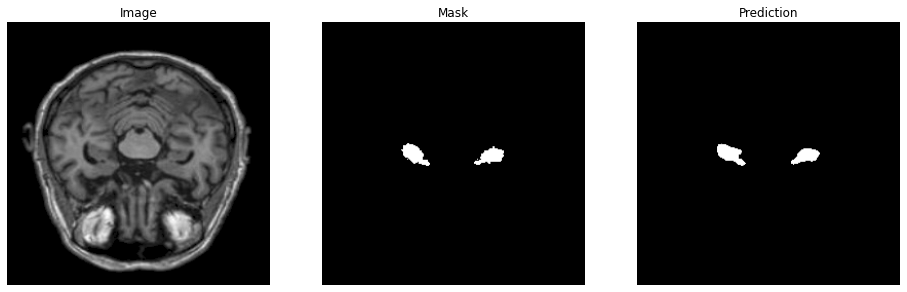

In [ ]:
f, axarr = plt.subplots(1, 3, figsize=(16,12))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Image")
axarr[0].axis('off')
axarr[1].imshow(msk, cmap = 'gray')
axarr[1].set_title("Mask")
axarr[1].axis('off')
axarr[2].imshow(output_data[0][0], cmap = 'gray')
axarr[2].set_title("Prediction")
axarr[2].axis('off')
f.show()

In [ ]:
dice, iou = metrics(output_data[0][0], msk)
print("Dice coeff:", dice)
print("IoU:", iou)

Dice coeff: 0.904
IoU: 0.816


#### Measure performance

In [ ]:
rails = pynq.get_rails()
recorder = pynq.DataRecorder(rails['PSINT_FP'].power)

In [ ]:
def run(idx):
    img = parse_image(test_images[idx], shapeIn[1])
    image[0,...] = img
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)

In [ ]:
def single_thread(start, end):
    [run(i) for i in range(start, end)]

In [ ]:
def measure_performances(threads=2):
    threadAll = []
    start=0
    for i in range(threads):
        if (i==threads-1):
            end = len(test_images)
        else:
            end = start+(len(test_images)//threads)
        t1 = threading.Thread(target=single_thread, args=(start, end))
        threadAll.append(t1)
        start=end

    with recorder.record(0.5):
        time1 = time.time()
        for x in threadAll:
            x.start()
        for x in threadAll:
            x.join()
        time2 = time.time()
        timetotal = time2 - time1
    
    fps = float(len(test_images) / timetotal)
    print("Throughput=%.2f fps, total frames = %.0f, time=%.4f seconds" %(fps, len(test_images), timetotal))
    return fps, np.mean(recorder.frame['PSINT_FP_power'])

In [ ]:
n_threads = 3
rounds = 3
fpss = []
powers = []

for i in range(rounds):
    print('Starting', i+1,'/', rounds, ' round...')
    fps, power = measure_performances(n_threads)
    fpss.append(fps)
    powers.append(power)

print("-----------------------------------------------------------------------")
print("Throughput: %.2f +- %.2f with power consumption of %.2f +- %.2f" %(np.mean(fpss), np.std(fpss), np.mean(powers), np.std(powers)))

Starting 1 / 3  round...
Throughput=15.65 fps, total frames = 529, time=33.8040 seconds
Starting 2 / 3  round...
Throughput=15.05 fps, total frames = 529, time=35.1563 seconds
Starting 3 / 3  round...
Throughput=15.07 fps, total frames = 529, time=35.0971 seconds
-----------------------------------------------------------------------
Throughput: 15.26 +- 0.28 with power consumption of 0.93 +- 0.00


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

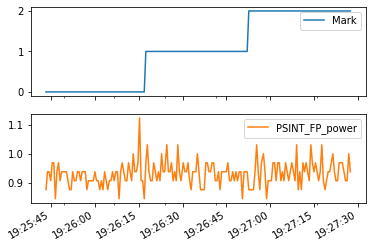

In [ ]:
recorder.frame.plot(subplots=True)

#### Metrics

In [ ]:
dice_scores = []
ious = []

for idx in range(len(test_images)):
    msk = parse_mask(test_masks[idx], shapeOut[1])
    img = parse_image(test_images[idx], shapeIn[1])
    image[0,...] = img
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    dice, iou = metrics(output_data[0][0], msk)
    dice_scores.append(dice)
    ious.append(iou)
    
print("Dice coeff: %.3f +- %.3f"%(np.mean(dice_scores), np.std(dice_scores)))
print("IoU: %.3f +- %.3f"%(np.mean(ious), np.std(ious)))

Dice coeff: 0.748 +- 0.235
IoU: 0.634 +- 0.231


#### Delete variables

In [ ]:
del overlay
del dpu